# pruning in pytorch

In [18]:
import torch
from apex.contrib.sparsity import ASP
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
def torchNet(dim, hidden_dim=128, num_classes=10):
    net = torch.nn.Sequential(
        torch.nn.Linear(in_features=dim, out_features=hidden_dim), 
        torch.nn.ReLU(), 
        torch.nn.Linear(in_features=hidden_dim, out_features=num_classes)
    )

    return net

torNet = torchNet(784, hidden_dim=128, num_classes=10)

In [ ]:
dataset = datasets.MNIST('../data', train=True, download=True)

In [3]:
ASP.init_model_for_pruning(torNet.cuda(), "m4n2_1d", allow_recompute_mask=True, verbosity=3)
ASP.compute_sparse_masks()

[ASP] torchvision is imported, can work with the MaskRCNN/KeypointRCNN from torchvision.

[set_permutation_params_from_asp] Set permutation needed parameters

[set_identical_seed] Set the identical seed: 1 for all GPUs to make sure the same results generated in permutation search
[ASP] Sparsifying 0::weight of size=torch.Size([128, 784]) and type=torch.float32 for sparsity
[ASP] Not sparsifying 0::bias of size=torch.Size([128]) and type=torch.float32
[ASP] Auto skipping pruning 2::weight of size=torch.Size([10, 128]) and type=torch.float32 for sparsity
[ASP] Not sparsifying 2::bias of size=torch.Size([10]) and type=torch.float32

[build_offline_permutation_graph] Further refine the model graph built by Torch.FX for offline permutation
[build_fx_graph] The torch version is: 1.13.0+cu116, version major is: 1, version minor is: 13, version minimum is: 0+cu116
[build_fx_graph] The Torch.FX is supported.

[build_fx_graph] Print the model structure with pure PyTorch function
Sequential(
  (0

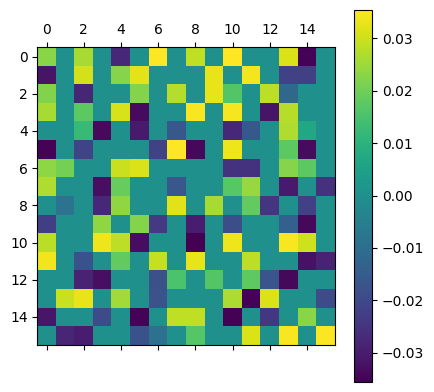

In [4]:
# mlpNet.state_dict()
Linear_1 = torNet.state_dict()['0.weight'].cpu()
L_1 = Linear_1[:16, :16]
plt.Figure(figsize=(30,30))
plt.matshow(L_1)
plt.colorbar()
plt.show()

# pruning in needle

In [6]:
import sys
sys.path.append('../python')

import numpy as np
import pytest
import needle as ndl
from needle import backend_ndarray as nd
import needle.nn as nn
import needle.optim as optim
from needle import data as ndldata
import needle.init as init
import needle.ops as ops
from needle.prune import model_to_sparse
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(4)

In [16]:
def MLPNet(dim, hidden_dim=128, num_classes=10, device=ndl.cpu_numpy()):
    ### BEGIN YOUR SOLUTION
    mlpNet = nn.Sequential(
        nn.Linear(in_features=dim, out_features=hidden_dim, device=device), 
        nn.ReLU(), 
        nn.Linear(in_features=hidden_dim, out_features=num_classes, device=device))
    return mlpNet

ndlNet = MLPNet(784, device=ndl.cuda())

In [3]:
# if error need to restart
model_to_sparse(ndlNet, device=ndl.cuda())

[ASP] torchvision is imported, can work with the MaskRCNN/KeypointRCNN from torchvision.

[set_permutation_params_from_asp] Set permutation needed parameters

[set_identical_seed] Set the identical seed: 1 for all GPUs to make sure the same results generated in permutation search
[ASP] Sparsifying 0::weight of size=torch.Size([128, 784]) and type=torch.float32 for sparsity
[ASP] Not sparsifying 0::bias of size=torch.Size([128]) and type=torch.float32
[ASP] Auto skipping pruning 2::weight of size=torch.Size([10, 128]) and type=torch.float32 for sparsity
[ASP] Not sparsifying 2::bias of size=torch.Size([10]) and type=torch.float32

[build_offline_permutation_graph] Further refine the model graph built by Torch.FX for offline permutation
[build_fx_graph] The torch version is: 1.13.0+cu116, version major is: 1, version minor is: 13, version minimum is: 0+cu116
[build_fx_graph] The Torch.FX is supported.

[build_fx_graph] Print the model structure with pure PyTorch function
Sequential(
  (0

In [4]:
ndlNet.parameters()

[needle.Tensor([[ 0.08171319  0.          0.08270254 ... -0.08046729 -0.08468738
    0.        ]
  [-0.03694269 -0.0731848  -0.         ... -0.         -0.
    0.        ]
  [-0.          0.         -0.         ... -0.06150609  0.04774623
   -0.08601174]
  ...
  [ 0.         -0.         -0.         ... -0.          0.
   -0.05783466]
  [ 0.08120847 -0.0660558  -0.07118365 ...  0.04720204 -0.
    0.07446385]
  [ 0.07222853 -0.06441209 -0.06232706 ... -0.         -0.05123587
   -0.        ]]),
 needle.Tensor([[-0.0408387  -0.14103304  0.1737385   0.10536192 -0.13558808  0.12015741
   -0.14866094 -0.04720072 -0.08737536  0.12414418 -0.14787999  0.2008941
   -0.13314563 -0.19094935  0.16716553  0.19224046 -0.20383927  0.20305012
   -0.04301809  0.18764515  0.17852257 -0.0497205  -0.2128783  -0.12349514
    0.1511579  -0.05741984 -0.11248378 -0.10633937 -0.19096266  0.14588036
    0.19168319 -0.18540105 -0.06894524  0.01998724 -0.16500823 -0.04089949
   -0.20627588 -0.08159663 -0.03098701  

TODO: refer https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

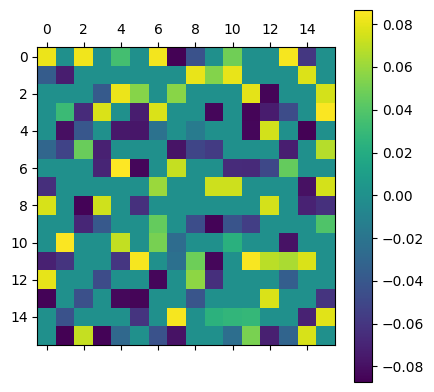

In [15]:
# mlpNet.state_dict()
Linear_1 = ndlNet.parameters()[0].numpy()
L_1 = Linear_1[:16, :16]

plt.Figure(figsize=(30,30))
plt.matshow(L_1)
plt.colorbar()
plt.show()